# Store Sales - Time Series Forecasting EDA

このノートブックでは、Store Salesデータセットを探索的に分析します。

目標:
- データセットの構造と特徴を理解する
- 時系列パターンを特定する
- 欠損値のパターンを特定する
- 売上に影響を与える要因を分析する
- 外部要因（原油価格、祝日）の影響を確認する

## 1. ライブラリのインポートとデータの読み込み

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# 設定
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [67]:
# データの読み込み
train_df = pd.read_csv('../data/raw/train.csv', parse_dates=['date'])
test_df = pd.read_csv('../data/raw/test.csv', parse_dates=['date'])
stores_df = pd.read_csv('../data/raw/stores.csv')
oil_df = pd.read_csv('../data/raw/oil.csv', parse_dates=['date'])
holidays_df = pd.read_csv('../data/raw/holidays_events.csv', parse_dates=['date'])
transactions_df = pd.read_csv('../data/raw/transactions.csv', parse_dates=['date'])

print(f"train: {train_df.shape[0]:,}行 × {train_df.shape[1]}列")
print(f"test: {test_df.shape[0]:,}行 × {test_df.shape[1]}列")
print(f"stores: {stores_df.shape[0]}店舗")
print(f"oil: {oil_df.shape[0]:,}日")
print(f"holidays: {holidays_df.shape[0]}件")
print(f"transactions: {transactions_df.shape[0]:,}件")

train: 3,000,888行 × 6列
test: 28,512行 × 5列
stores: 54店舗
oil: 1,218日
holidays: 350件
transactions: 83,488件


## 2. 訓練データの基本情報

In [68]:
# 最初の5行を表示
print("=== 訓練データの最初の5行 ===")
train_df.head()

=== 訓練データの最初の5行 ===


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [69]:
# データ型と欠損値の確認
print("=== データの情報 ===")
train_df.info()

=== データの情報 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [70]:
# 基本統計量
print("=== 数値データの基本統計量 ===")
train_df.describe()

=== 数値データの基本統計量 ===


,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [71]:
# 日付範囲を確認
print(f"訓練データ期間: {train_df['date'].min()} ～ {train_df['date'].max()}")
print(f"テストデータ期間: {test_df['date'].min()} ～ {test_df['date'].max()}")
print(f"\n訓練データ日数: {(train_df['date'].max() - train_df['date'].min()).days}日")
print(f"テストデータ日数: {(test_df['date'].max() - test_df['date'].min()).days}日")

訓練データ期間: 2013-01-01 00:00:00 ～ 2017-08-15 00:00:00
テストデータ期間: 2017-08-16 00:00:00 ～ 2017-08-31 00:00:00

訓練データ日数: 1687日
テストデータ日数: 15日


## 3. 店舗と商品ファミリーの情報

In [72]:
# 店舗情報
print("=== 店舗情報 ===")
print(stores_df.head())
print(f"\n店舗数: {stores_df['store_nbr'].nunique()}")
print(f"\n都市数: {stores_df['city'].nunique()}")
print(f"州数: {stores_df['state'].nunique()}")
print(f"店舗タイプ: {stores_df['type'].unique()}")
print(f"クラスター数: {stores_df['cluster'].nunique()}")

=== 店舗情報 ===
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

店舗数: 54

都市数: 22
州数: 16
店舗タイプ: ['D' 'B' 'C' 'E' 'A']
クラスター数: 17


In [73]:
# 商品ファミリーの情報
print("=== 商品ファミリー ===")
families = train_df['family'].unique()
print(f"商品ファミリー数: {len(families)}")
print(f"\n商品ファミリー一覧:")
for i, family in enumerate(sorted(families), 1):
    print(f"{i:2d}. {family}")

=== 商品ファミリー ===
商品ファミリー数: 33

商品ファミリー一覧:
 1. AUTOMOTIVE
 2. BABY CARE
 3. BEAUTY
 4. BEVERAGES
 5. BOOKS
 6. BREAD/BAKERY
 7. CELEBRATION
 8. CLEANING
 9. DAIRY
10. DELI
11. EGGS
12. FROZEN FOODS
13. GROCERY I
14. GROCERY II
15. HARDWARE
16. HOME AND KITCHEN I
17. HOME AND KITCHEN II
18. HOME APPLIANCES
19. HOME CARE
20. LADIESWEAR
21. LAWN AND GARDEN
22. LINGERIE
23. LIQUOR,WINE,BEER
24. MAGAZINES
25. MEATS
26. PERSONAL CARE
27. PET SUPPLIES
28. PLAYERS AND ELECTRONICS
29. POULTRY
30. PREPARED FOODS
31. PRODUCE
32. SCHOOL AND OFFICE SUPPLIES
33. SEAFOOD


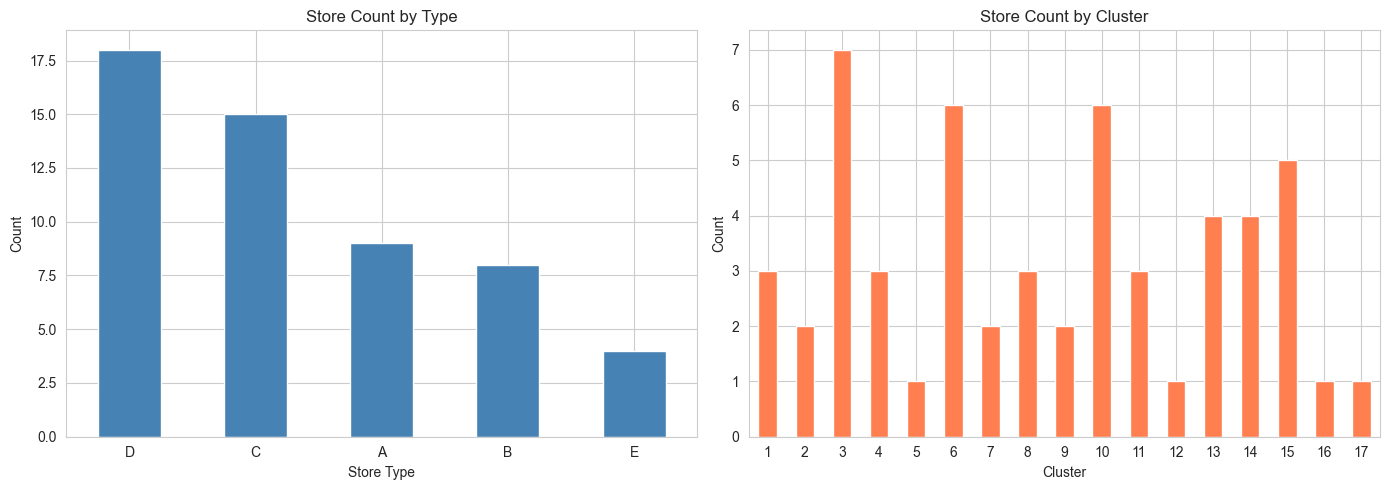

In [74]:
# 店舗タイプ別の分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 店舗タイプ別の店舗数
stores_df['type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Store Count by Type')
axes[0].set_xlabel('Store Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# クラスター別の店舗数
stores_df['cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Store Count by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 4. 売上の時系列パターン分析

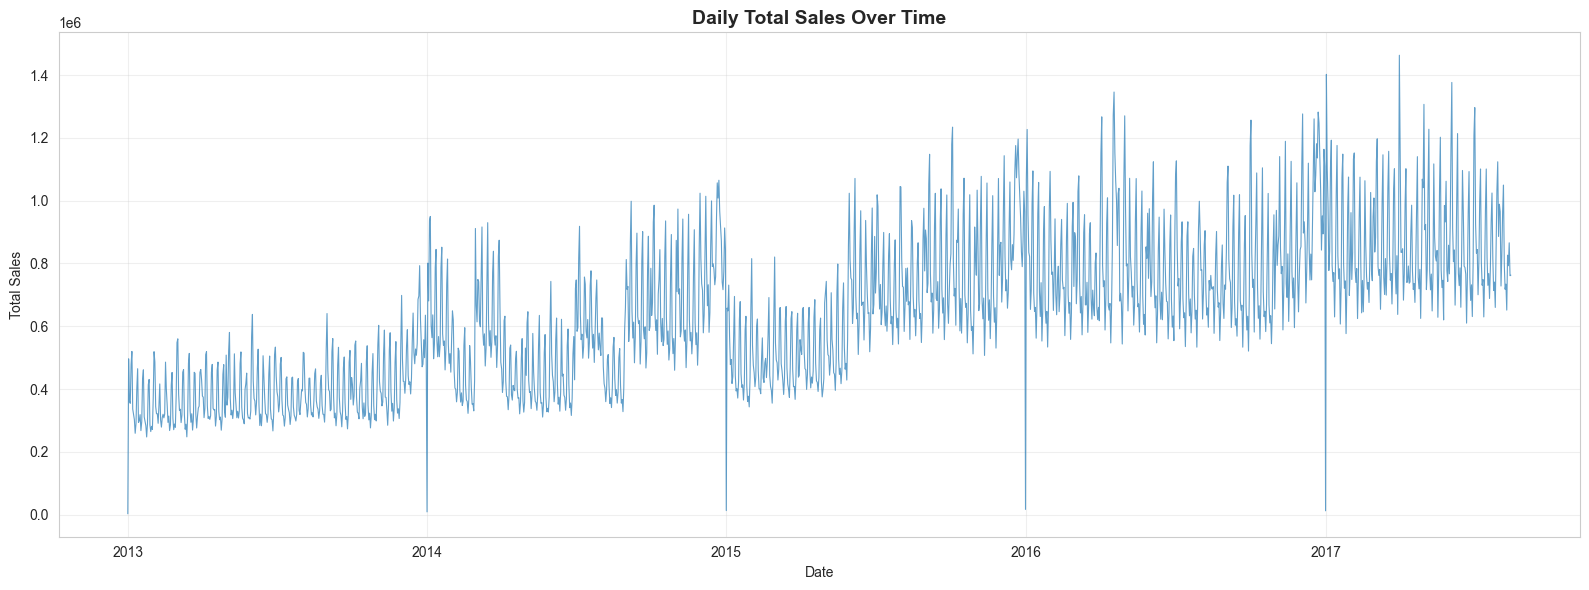

平均日次売上: $637,556.38
中央値日次売上: $632,188.86
最大日次売上: $1,463,083.96
最小日次売上: $2,511.62


In [75]:
# 日次の総売上推移
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(16, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], alpha=0.7, linewidth=0.8)
plt.title('Daily Total Sales Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"平均日次売上: ${daily_sales['sales'].mean():,.2f}")
print(f"中央値日次売上: ${daily_sales['sales'].median():,.2f}")
print(f"最大日次売上: ${daily_sales['sales'].max():,.2f}")
print(f"最小日次売上: ${daily_sales['sales'].min():,.2f}")

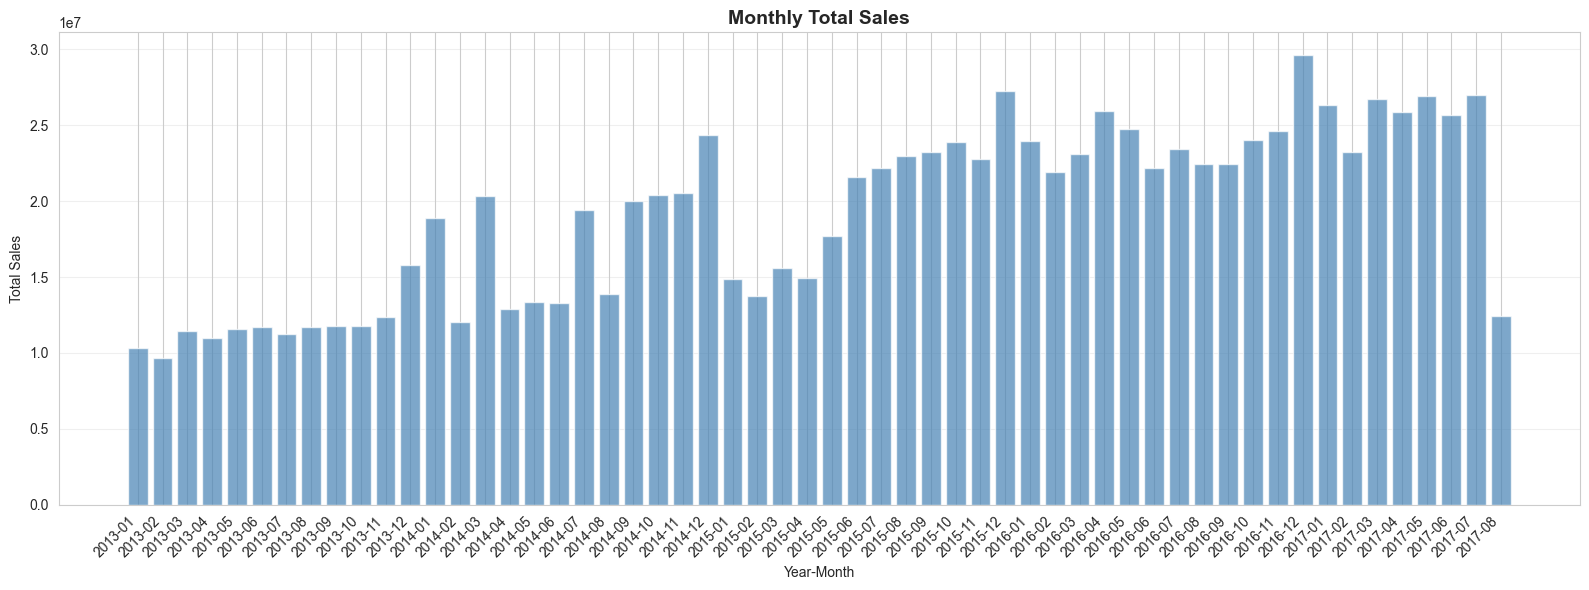

In [76]:
# 月次の売上推移
train_df['year_month'] = train_df['date'].dt.to_period('M')
monthly_sales = train_df.groupby('year_month')['sales'].sum().reset_index()
monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

plt.figure(figsize=(16, 6))
plt.bar(monthly_sales['year_month'], monthly_sales['sales'], alpha=0.7, color='steelblue')
plt.title('Monthly Total Sales', fontsize=14, fontweight='bold')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

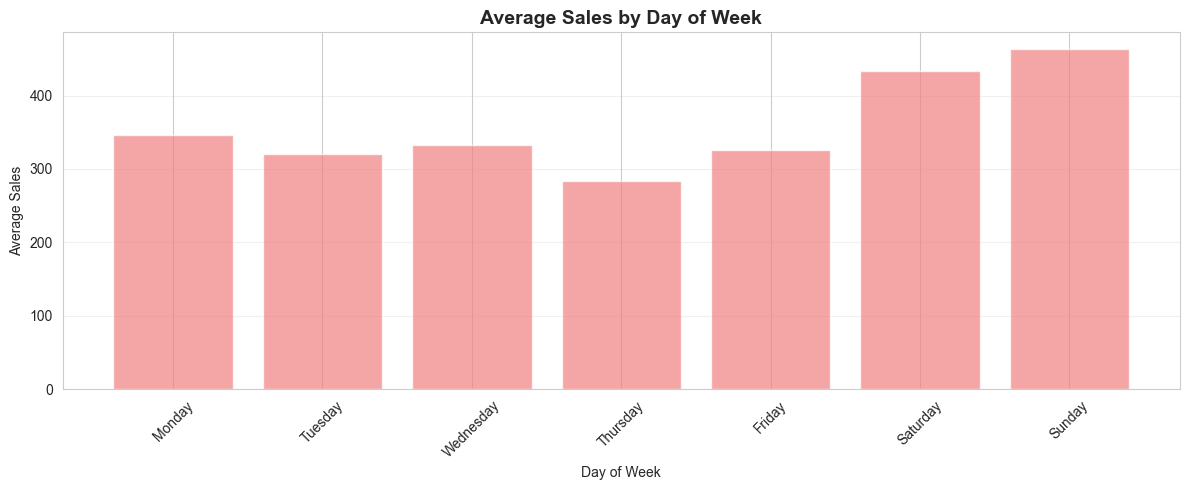

In [77]:
# 曜日別の売上パターン
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['day_name'] = train_df['date'].dt.day_name()

dow_sales = train_df.groupby('day_of_week')['sales'].mean().reset_index()
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 5))
plt.bar(dow_names, dow_sales['sales'], color='lightcoral', alpha=0.7)
plt.title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

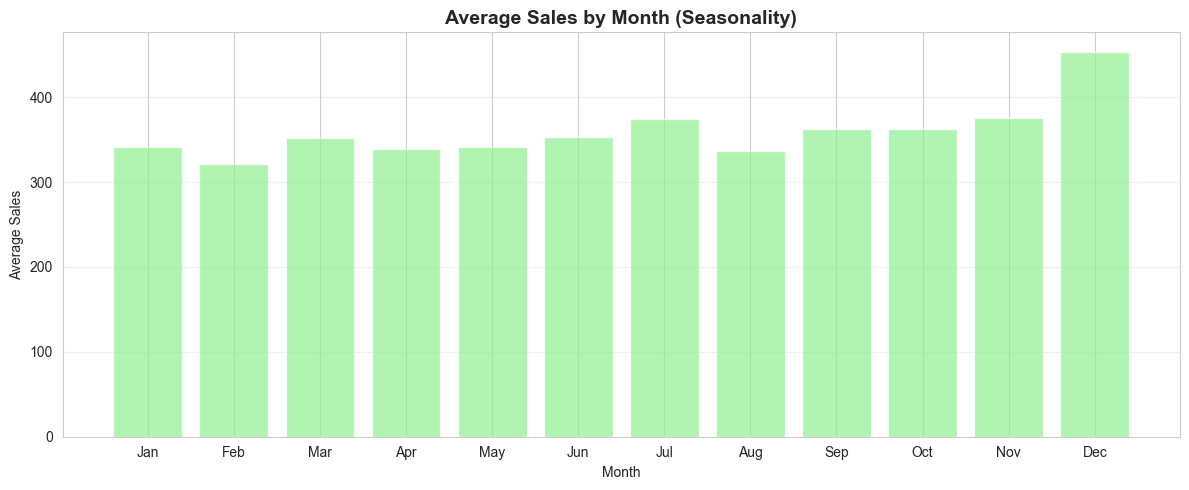

In [78]:
# 月別の売上パターン（季節性）
train_df['month'] = train_df['date'].dt.month
monthly_pattern = train_df.groupby('month')['sales'].mean().reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 5))
plt.bar(month_names, monthly_pattern['sales'], color='lightgreen', alpha=0.7)
plt.title('Average Sales by Month (Seasonality)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. 店舗別・商品ファミリー別の売上分析

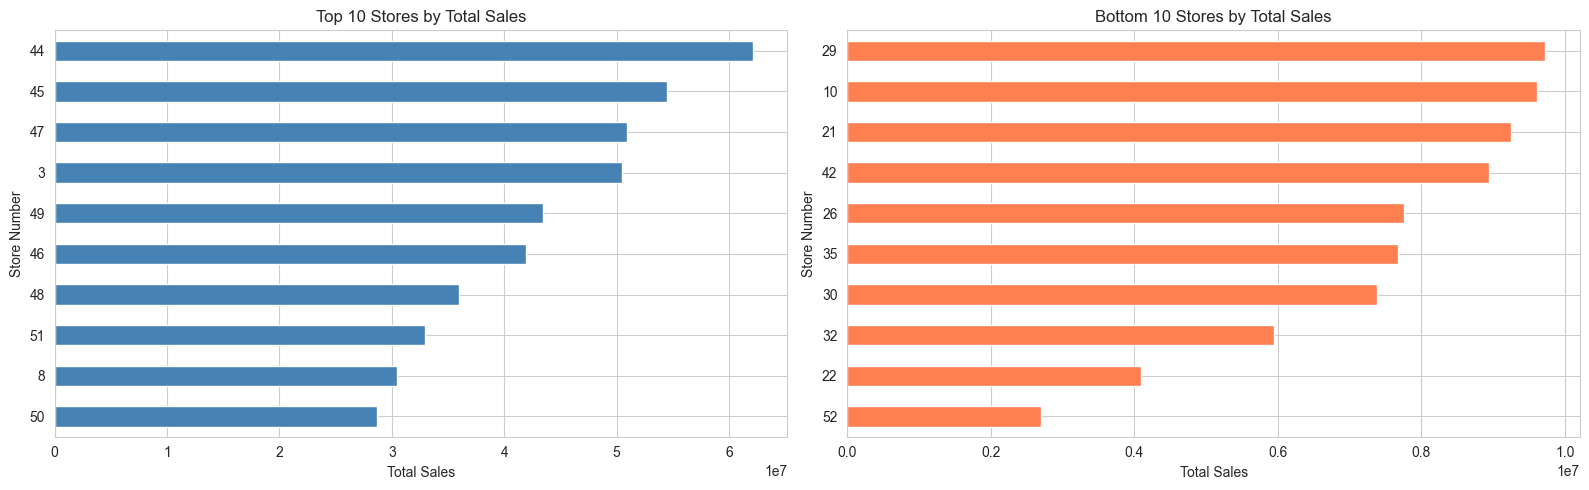

In [79]:
# 店舗別の総売上TOP 10
store_sales = train_df.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# TOP 10店舗
store_sales.head(10).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 Stores by Total Sales')
axes[0].set_xlabel('Total Sales')
axes[0].set_ylabel('Store Number')
axes[0].invert_yaxis()

# BOTTOM 10店舗
store_sales.tail(10).plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Bottom 10 Stores by Total Sales')
axes[1].set_xlabel('Total Sales')
axes[1].set_ylabel('Store Number')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

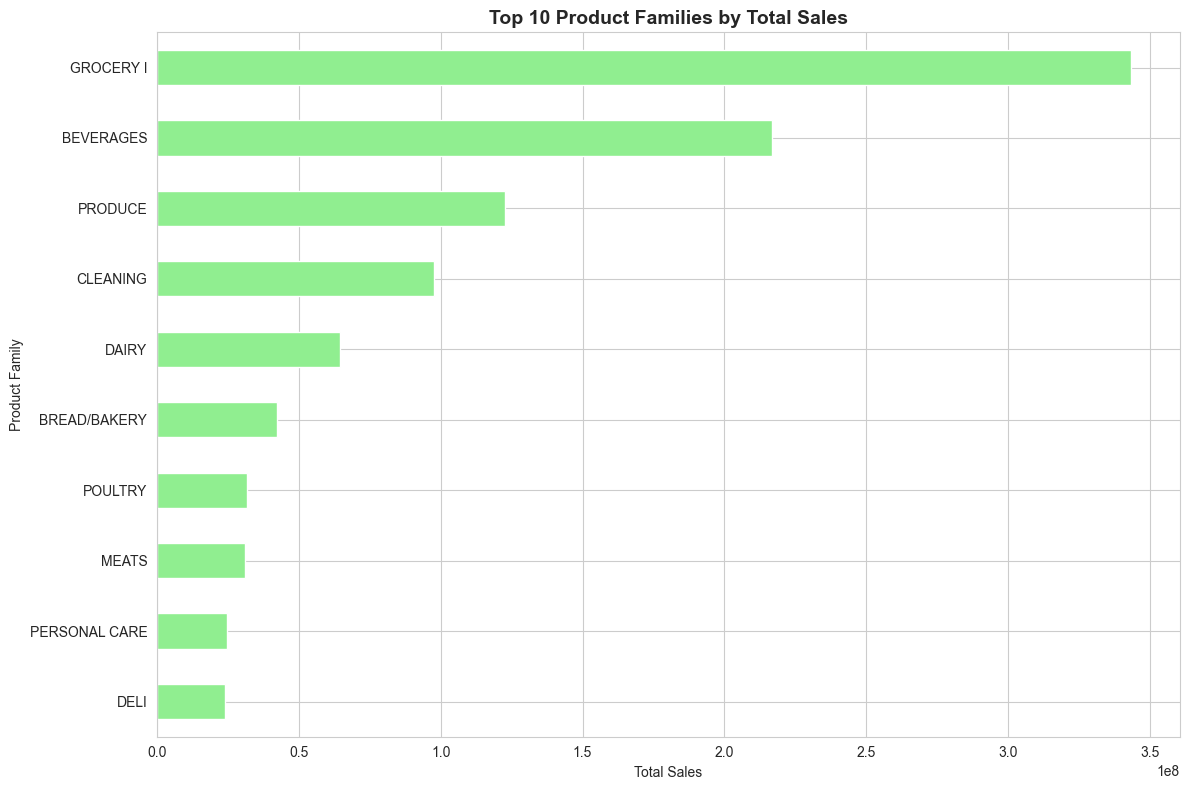


=== TOP 5 商品ファミリー ===
1. GROCERY I: $343,462,734.89
2. BEVERAGES: $216,954,486.00
3. PRODUCE: $122,704,684.68
4. CLEANING: $97,521,289.00
5. DAIRY: $64,487,709.00


In [80]:
# 商品ファミリー別の総売上TOP 10
family_sales = train_df.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
family_sales.head(10).plot(kind='barh', color='lightgreen')
plt.title('Top 10 Product Families by Total Sales', fontsize=14, fontweight='bold')
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n=== TOP 5 商品ファミリー ===")
for i, (family, sales) in enumerate(family_sales.head().items(), 1):
    print(f"{i}. {family}: ${sales:,.2f}")

## 6. プロモーションの影響分析

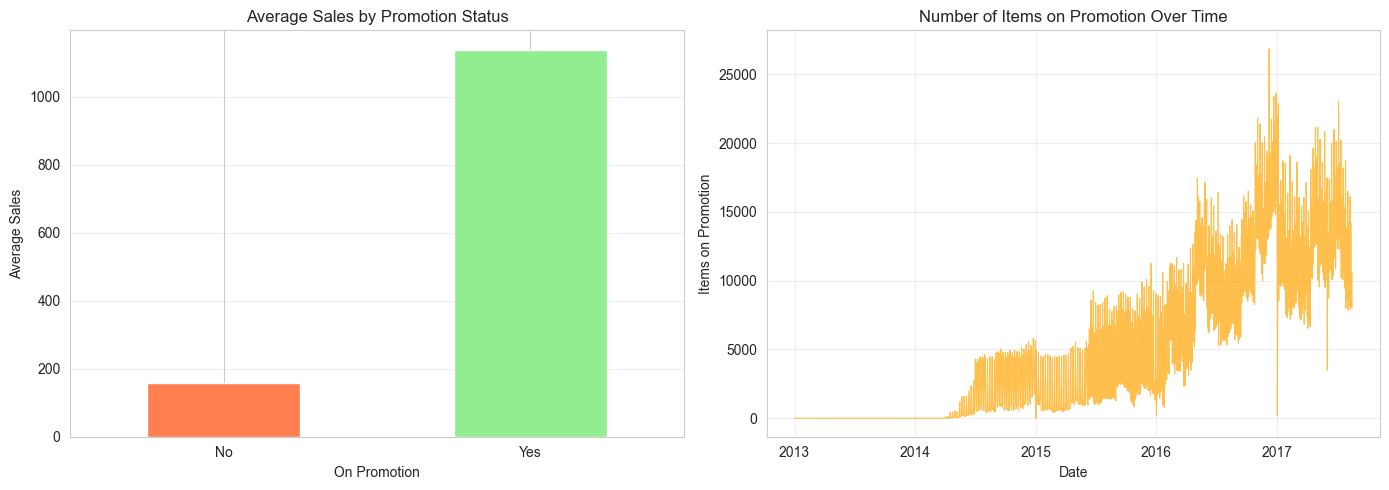

プロモーションなし平均売上: $158.25
プロモーションあり平均売上: $1137.69
売上向上率: 618.94%


In [81]:
# プロモーション有無による売上の比較
# onpromotiontがプロモーション中の商品数なので、0より大きいかどうかでプロモーション有無を判定
train_df['has_promotion'] = (train_df['onpromotion'] > 0).astype(int)
promo_sales = train_df.groupby('has_promotion')['sales'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 平均売上の比較
promo_sales.plot(kind='bar', ax=axes[0], color=['coral', 'lightgreen'])
axes[0].set_title('Average Sales by Promotion Status')
axes[0].set_xlabel('On Promotion')
axes[0].set_ylabel('Average Sales')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)
axes[0].grid(alpha=0.3, axis='y')

# プロモーション商品数の推移
promo_count = train_df.groupby('date')['onpromotion'].sum().reset_index()
axes[1].plot(promo_count['date'], promo_count['onpromotion'], alpha=0.7, linewidth=0.8, color='orange')
axes[1].set_title('Number of Items on Promotion Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Items on Promotion')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"プロモーションなし平均売上: ${promo_sales[0]:.2f}")
print(f"プロモーションあり平均売上: ${promo_sales[1]:.2f}")
print(f"売上向上率: {((promo_sales[1] / promo_sales[0]) - 1) * 100:.2f}%")

## 7. 原油価格の影響

In [82]:
# 原油価格データの確認
print("=== 原油価格データ ===")
print(oil_df.head())
print(f"\n欠損値: {oil_df['dcoilwtico'].isnull().sum()}件 ({oil_df['dcoilwtico'].isnull().sum() / len(oil_df) * 100:.1f}%)")
print(f"平均価格: ${oil_df['dcoilwtico'].mean():.2f}")
print(f"最高価格: ${oil_df['dcoilwtico'].max():.2f}")
print(f"最低価格: ${oil_df['dcoilwtico'].min():.2f}")

=== 原油価格データ ===
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

欠損値: 43件 (3.5%)
平均価格: $67.71
最高価格: $110.62
最低価格: $26.19


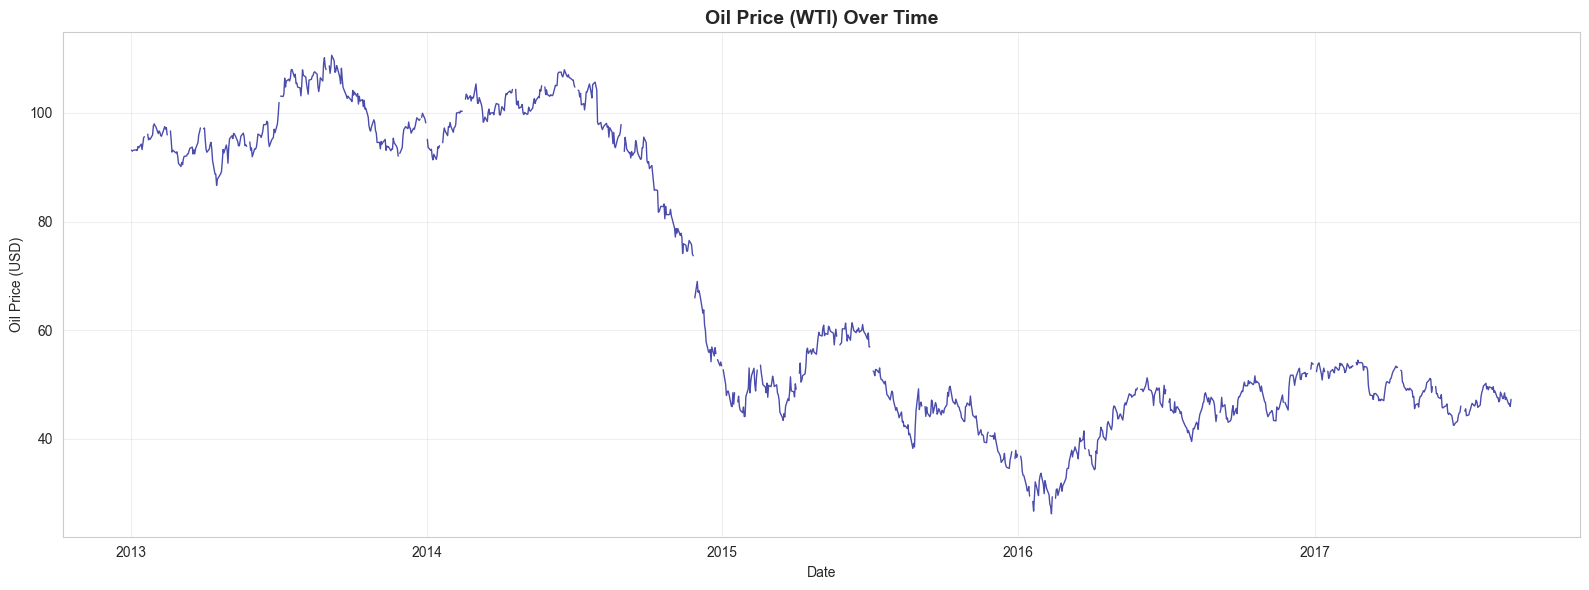

In [83]:
# 原油価格の推移
plt.figure(figsize=(16, 6))
plt.plot(oil_df['date'], oil_df['dcoilwtico'], alpha=0.7, linewidth=1, color='darkblue')
plt.title('Oil Price (WTI) Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

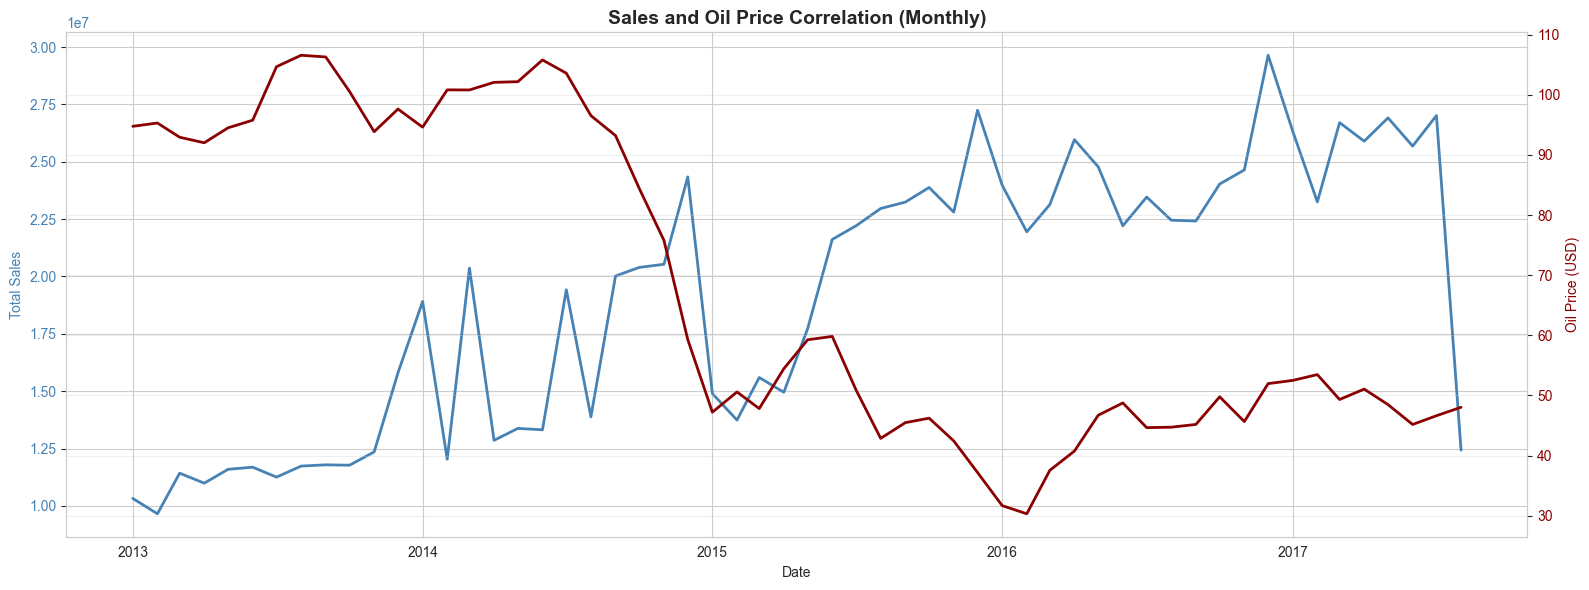


売上と原油価格の相関係数: -0.750


In [84]:
# 売上と原油価格の相関（月次集計）
# 日次売上を月次に集計
monthly_sales_all = train_df.groupby(train_df['date'].dt.to_period('M'))['sales'].sum().reset_index()
monthly_sales_all['date'] = monthly_sales_all['date'].dt.to_timestamp()

# 原油価格も月次平均に集計
oil_df['year_month'] = oil_df['date'].dt.to_period('M')
monthly_oil = oil_df.groupby('year_month')['dcoilwtico'].mean().reset_index()
monthly_oil['date'] = monthly_oil['year_month'].dt.to_timestamp()

# マージ
merged = pd.merge(monthly_sales_all, monthly_oil[['date', 'dcoilwtico']], on='date', how='inner')

fig, ax1 = plt.subplots(figsize=(16, 6))

# 売上
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales', color='steelblue')
ax1.plot(merged['date'], merged['sales'], color='steelblue', linewidth=2, label='Sales')
ax1.tick_params(axis='y', labelcolor='steelblue')

# 原油価格
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (USD)', color='darkred')
ax2.plot(merged['date'], merged['dcoilwtico'], color='darkred', linewidth=2, label='Oil Price')
ax2.tick_params(axis='y', labelcolor='darkred')

plt.title('Sales and Oil Price Correlation (Monthly)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 相関係数
correlation = merged[['sales', 'dcoilwtico']].corr().iloc[0, 1]
print(f"\n売上と原油価格の相関係数: {correlation:.3f}")

## 8. 祝日・イベントの影響

In [85]:
# 祝日データの確認
print("=== 祝日・イベントデータ ===")
print(holidays_df.head(10))
print(f"\n祝日/イベント数: {len(holidays_df)}件")
print(f"\nタイプ別:")
print(holidays_df['type'].value_counts())
print(f"\nロケール別:")
print(holidays_df['locale'].value_counts())

=== 祝日・イベントデータ ===
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   
5 2012-05-12  Holiday     Local        Puyo         Cantonizacion del Puyo   
6 2012-06-23  Holiday     Local    Guaranda      Cantonizacion de Guaranda   
7 2012-06-25  Holiday  Regional    Imbabura  Provincializacion de Imbabura   
8 2012-06-25  Holiday     Local   Latacunga     Cantonizacion de Latacunga   
9 2012-06-25  Holiday     Local     Machala           Fundacion de Machala   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6  

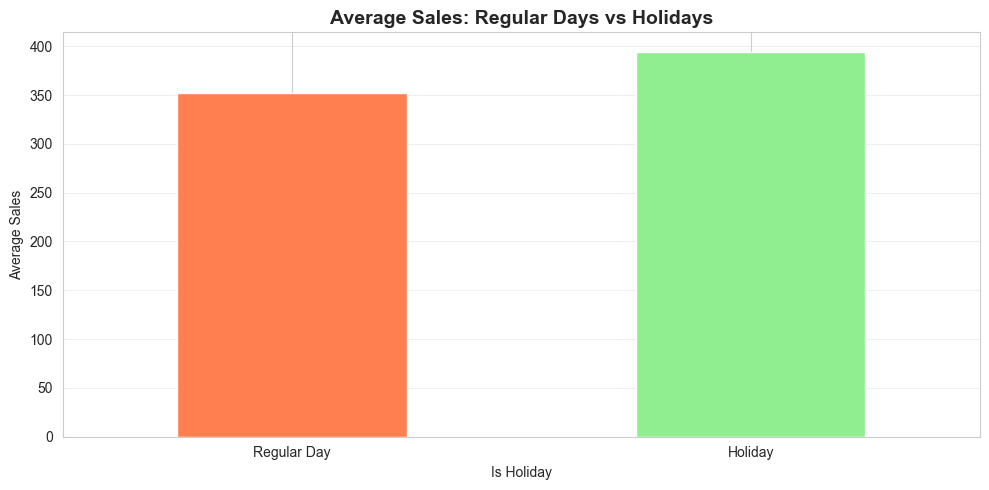

通常日の平均売上: $352.16
祝日の平均売上: $394.55
売上変化率: 12.04%


In [86]:
# 祝日前後の売上変化
# 訓練データに祝日フラグを追加
train_with_holiday = train_df.merge(
    holidays_df[['date', 'type']].drop_duplicates(),
    on='date',
    how='left'
)
train_with_holiday['is_holiday'] = train_with_holiday['type'].notna()

# 祝日有無による平均売上
holiday_sales = train_with_holiday.groupby('is_holiday')['sales'].mean()

plt.figure(figsize=(10, 5))
holiday_sales.plot(kind='bar', color=['coral', 'lightgreen'])
plt.title('Average Sales: Regular Days vs Holidays', fontsize=14, fontweight='bold')
plt.xlabel('Is Holiday')
plt.ylabel('Average Sales')
plt.xticks([0, 1], ['Regular Day', 'Holiday'], rotation=0)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"通常日の平均売上: ${holiday_sales[False]:.2f}")
print(f"祝日の平均売上: ${holiday_sales[True]:.2f}")
print(f"売上変化率: {((holiday_sales[True] / holiday_sales[False]) - 1) * 100:.2f}%")

## 9. トランザクション数の分析

In [87]:
# トランザクション数の推移
print("=== トランザクションデータ ===")
print(transactions_df.head())
print(f"\nデータ期間: {transactions_df['date'].min()} ～ {transactions_df['date'].max()}")

=== トランザクションデータ ===
        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

データ期間: 2013-01-01 00:00:00 ～ 2017-08-15 00:00:00


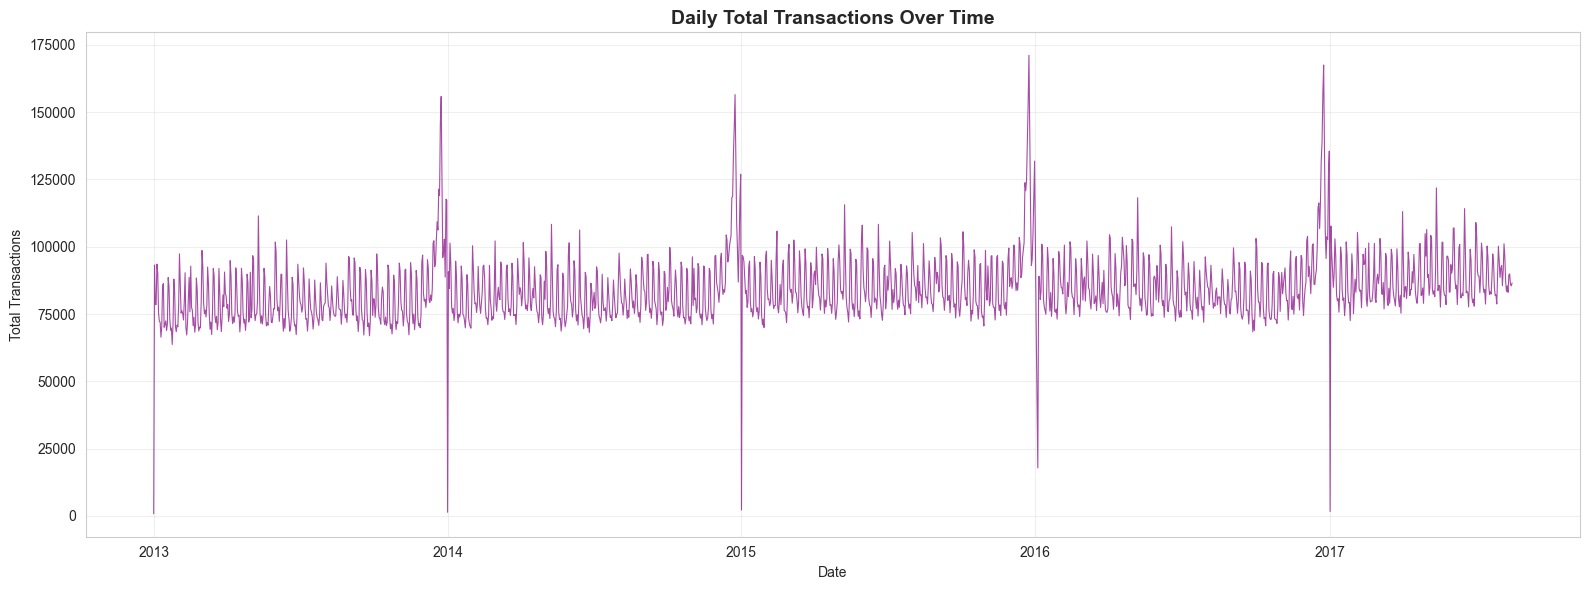

In [88]:
# 日次のトランザクション数推移
daily_transactions = transactions_df.groupby('date')['transactions'].sum().reset_index()

plt.figure(figsize=(16, 6))
plt.plot(daily_transactions['date'], daily_transactions['transactions'], alpha=0.7, linewidth=0.8, color='purple')
plt.title('Daily Total Transactions Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

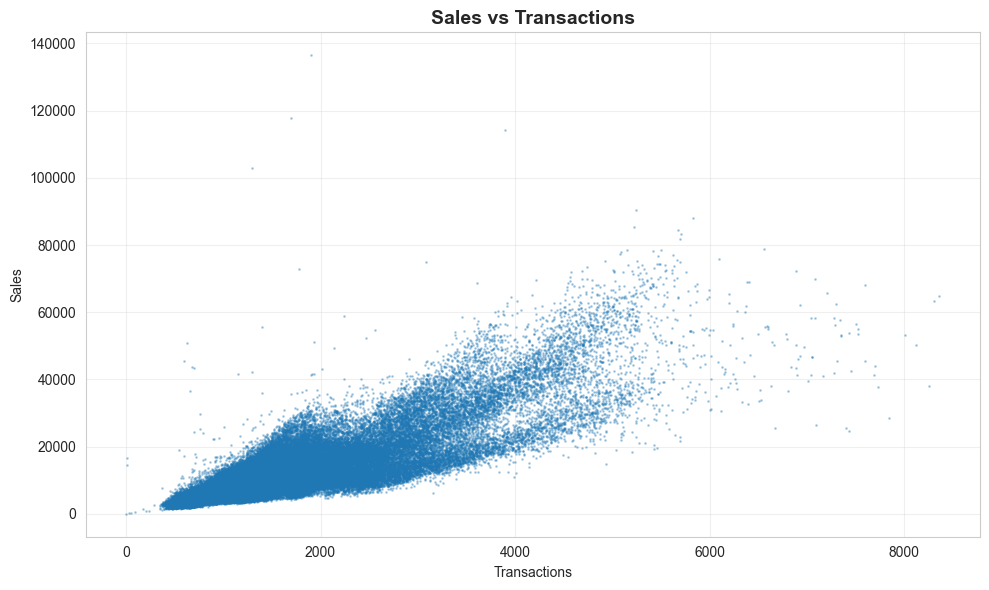


売上とトランザクション数の相関係数: 0.837


In [89]:
# 売上とトランザクション数の相関
# 店舗×日付で売上を集計
store_daily_sales = train_df.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()

# トランザクションデータとマージ
merged_trans = pd.merge(store_daily_sales, transactions_df, on=['date', 'store_nbr'], how='inner')

# 散布図
plt.figure(figsize=(10, 6))
plt.scatter(merged_trans['transactions'], merged_trans['sales'], alpha=0.3, s=1)
plt.title('Sales vs Transactions', fontsize=14, fontweight='bold')
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 相関係数
correlation_trans = merged_trans[['sales', 'transactions']].corr().iloc[0, 1]
print(f"\n売上とトランザクション数の相関係数: {correlation_trans:.3f}")

## 10. ゼロ売上の分析

ゼロ売上のレコード数: 939,130件
ゼロ売上の割合: 31.30%


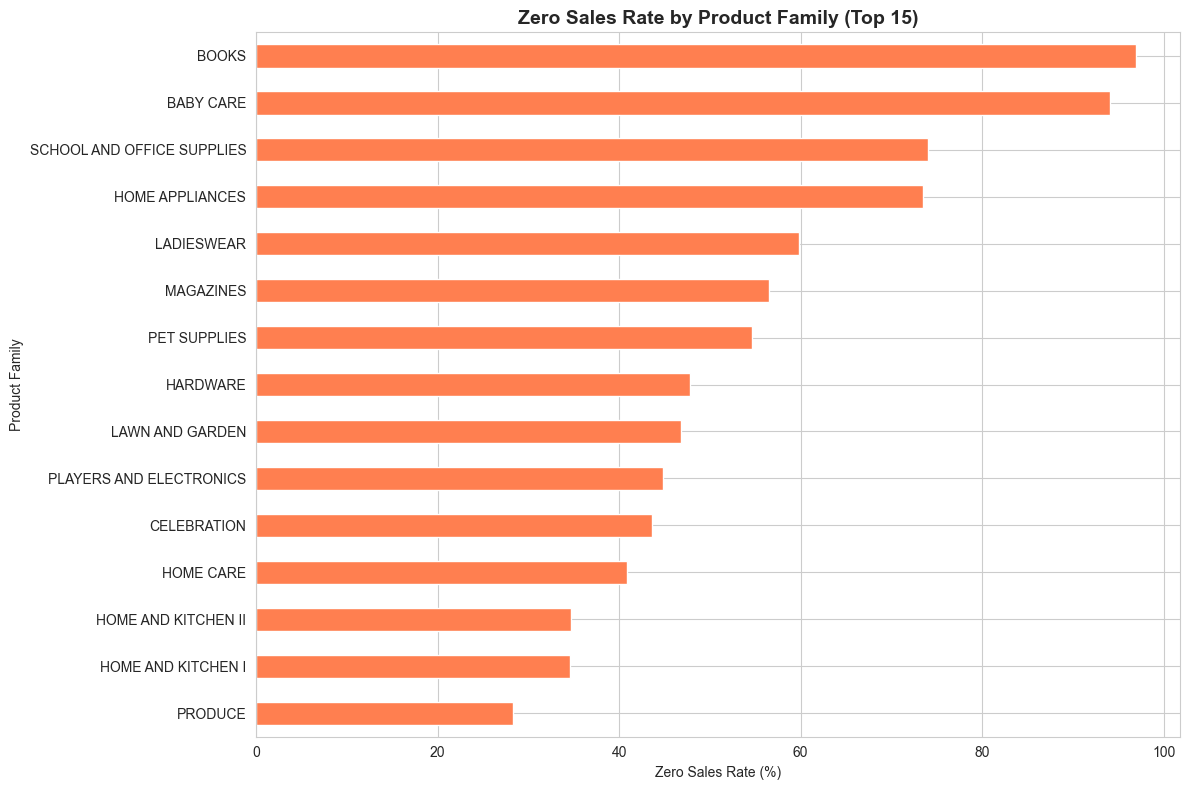

In [90]:
# ゼロ売上の割合
zero_sales = (train_df['sales'] == 0).sum()
zero_rate = zero_sales / len(train_df) * 100

print(f"ゼロ売上のレコード数: {zero_sales:,}件")
print(f"ゼロ売上の割合: {zero_rate:.2f}%")

# 商品ファミリー別のゼロ売上率
zero_by_family = train_df.groupby('family').apply(
    lambda x: (x['sales'] == 0).sum() / len(x) * 100
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
zero_by_family.head(15).plot(kind='barh', color='coral')
plt.title('Zero Sales Rate by Product Family (Top 15)', fontsize=14, fontweight='bold')
plt.xlabel('Zero Sales Rate (%)')
plt.ylabel('Product Family')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## まとめ

このEDAを通じて以下のことがわかりました：

### 主要な発見:
1. **データ規模**: 訓練データは300万行以上、54店舗、33商品ファミリー
2. **期間**: 2013年1月〜2017年8月の約4.5年間
3. **時系列パターン**:
   - 明確な季節性が存在（12月に売上ピーク）
   - 曜日パターンあり（週末に売上増加傾向）
   - 年々増加トレンド
4. **プロモーション**: プロモーション商品は売上が高い
5. **外部要因**:
   - 原油価格との相関あり（エクアドル経済への影響）
   - 祝日は売上に影響
6. **ゼロ売上**: 一定割合のゼロ売上が存在（商品ファミリーによって差異）
7. **トランザクション**: 売上と強い相関

### 次のステップ:
- 欠損値の補完（原油価格）
- 時系列特徴量の作成（ラグ特徴量、移動平均など）
- 祝日・イベント特徴量の作成
- 店舗・商品ファミリーのエンコーディング
- DuckDB + dbtによる特徴量パイプラインの構築